In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score

# Load Dataset

In [2]:
df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")
gender_submission = pd.read_csv("/content/gender_submission.csv")

# About data

In [3]:
print(df.head())
print(df.info())
print(df.describe())
print(df.isna().sum())
print(test_df.head())
print(test_df.info())
print(test_df.describe())
print(test_df.isna().sum())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

# Preprocessing

In [4]:
def preprocessing(train_df, test_df):
    data = pd.concat([train_df, test_df], sort=False)

    # Fill missing values
    data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
    data['Age'] = data['Age'].fillna(data['Age'].median())
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())

    # Feature engineering
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

    # Drop unnecessary columns
    data = data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

    # Convert categorical to numerical
    data = pd.get_dummies(data, columns=['Sex', 'Embarked'], drop_first=True)

    train = data.iloc[:len(train_df)]
    test = data.iloc[len(train_df):]

    return train, test

train, test = preprocessing(df, test_df)

# Correlation Heatmap

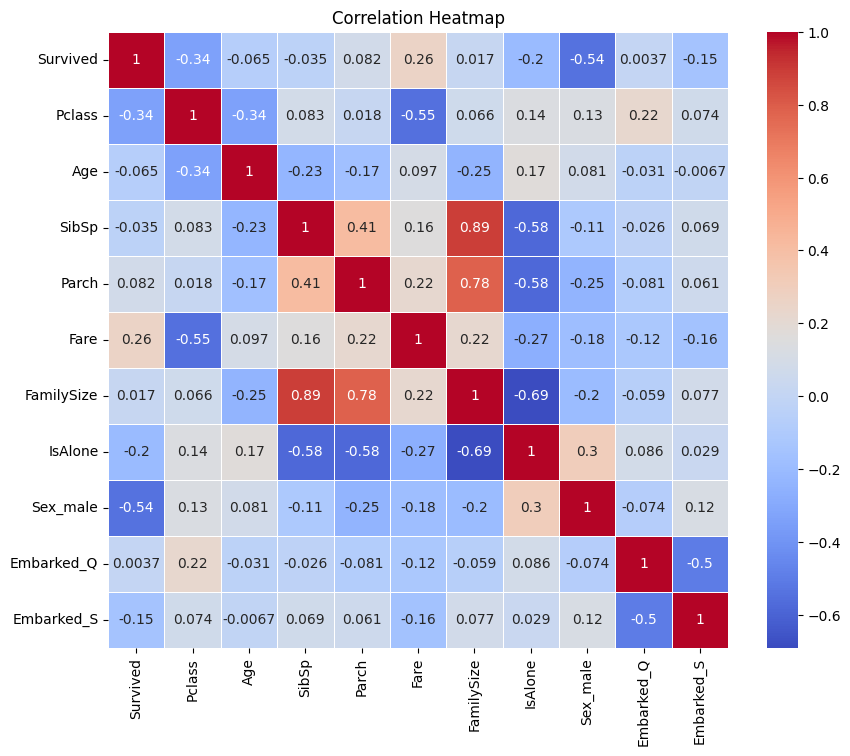

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Split Features and Target

In [6]:
X = train.drop('Survived', axis=1)
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Features

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test_scaled = scaler.transform(test.drop('Survived', axis=1))

# Model training and evaluation

In [8]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    return model

# **SVM**

Accuracy: 0.8156
              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85       105
         1.0       0.82      0.72      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179



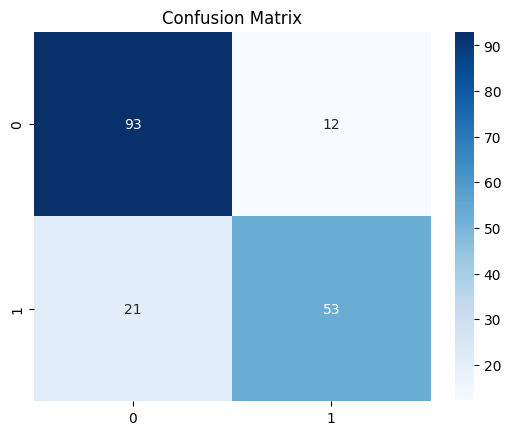

SVC(random_state=42)

In [9]:
svm_model = SVC(kernel='rbf', random_state=42)
evaluate_model(svm_model, X_train, y_train, X_test, y_test)

# **Logistic Regression**

Accuracy: 0.7989
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.83       105
         1.0       0.77      0.73      0.75        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



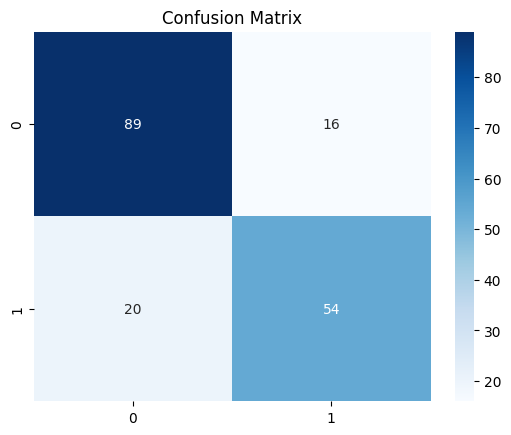

LogisticRegression(max_iter=1500, random_state=42)

In [10]:
logreg_model = LogisticRegression(random_state=42, max_iter=1500)
evaluate_model(logreg_model, X_train, y_train, X_test, y_test)

# **Random Forest with Hyperparameter Tuning**

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Accuracy: 0.8212
              precision    recall  f1-score   support

         0.0       0.81      0.91      0.86       105
         1.0       0.85      0.69      0.76        74

    accuracy                           0.82       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



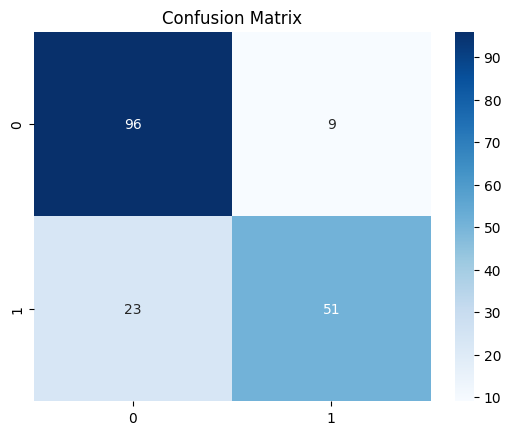

Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}


In [11]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

best_rf = grid_search.fit(X_train, y_train)
evaluate_model(best_rf.best_estimator_, X_train, y_train, X_test, y_test)
print(f"Best parameters: {grid_search.best_params_}")


In [12]:
final_predictions = best_rf.best_estimator_.predict(test_scaled)
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': final_predictions})
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv('Final.csv', index=False)
print("Submission file saved as 'Final.csv'")

Submission file saved as 'Final.csv'
